<a href="https://colab.research.google.com/github/Ankit-exe/Anime-Character-Generator/blob/main/Anime_character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2

import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from google.colab import files
from torch.utils.data import Dataset, DataLoader

In [4]:
# Setting seed
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

In [8]:
# Configuration
IMAGE_SIZE = 64
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 20
NOISE_DIM = 100
num_examples_to_generate = 9
LEARNING_RATE = 0.0002
GENERATOR_LR = 0.0005
DISCRIMINATOR_LR = 0.0002

# It is good to have higher lr for the generator than discriminator because we dont want out discriminator to be so good

In [9]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(f"GPU NAME: {torch.cuda.get_device_name(0)}")

In [15]:
!pip install opendatasets

In [18]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/splcher/animefacedataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitexe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:02<00:00, 206MB/s]


In [24]:
# DATASET PATH
DATASET_PATH = "animefacedataset/images"

if not os.path.exists(DATASET_PATH):
  print("Dataset not found")
else:
   print("dataset exists")

dataset exists


In [33]:
image_files = []
valid_extensions = ('.jpg','.jpeg','.png','.bmp')

for file in os.listdir(DATASET_PATH):
  if files.lower().endswith(valid_extensions):
    image_files.append(file)

print(f"Total images: {len(image_files)}")
print(f"Sample files:{image_files[:5]}")

Total images: 63565
Sample files:['11116_2005.jpg', '18288_2007.jpg', '14081_2006.jpg', '42659_2013.jpg', '38585_2012.jpg']


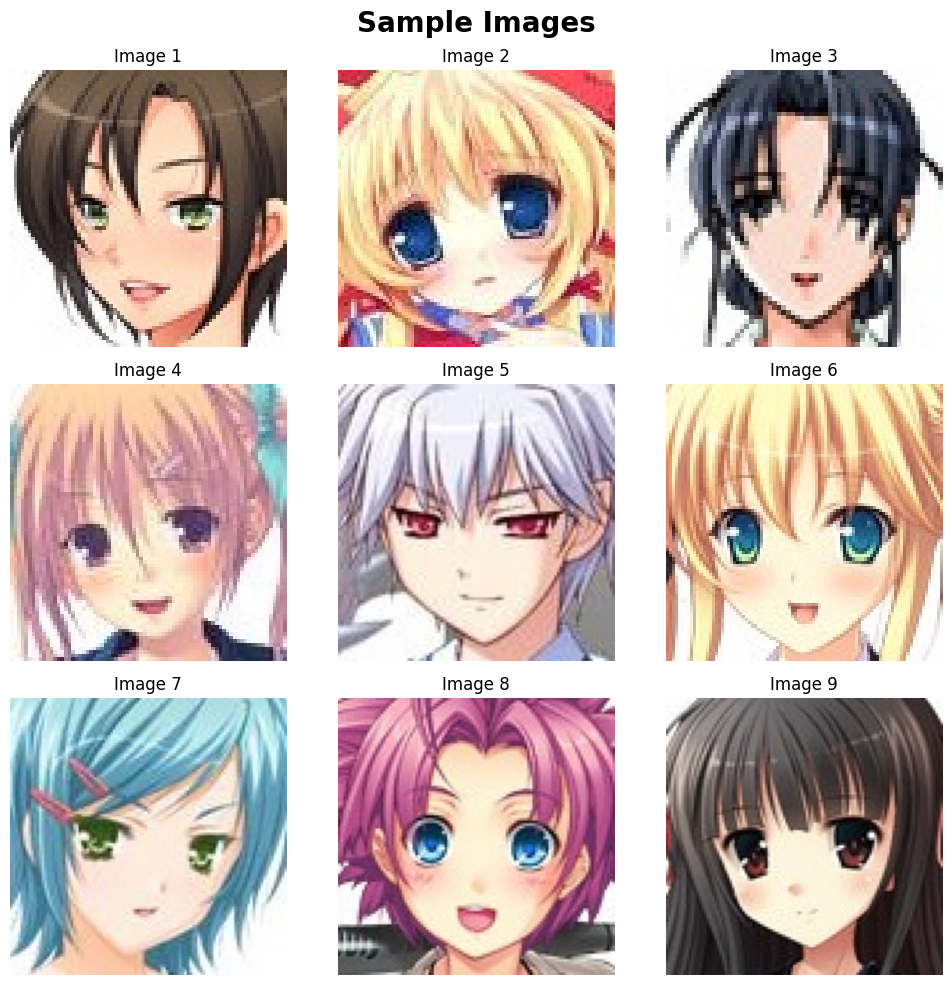

In [39]:
# Visualizing the Dataset

def display_sample_images(image_files,DATASET_PATH,num_samples = 9):
  fig, axes = plt.subplots(3,3,figsize=(10,10))
  fig.suptitle("Sample Images",fontsize=20, fontweight='bold')

  sample_files = np.random.choice(image_files,num_samples,replace=False)

  for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(DATASET_PATH,sample_files[i])
    try:
      img = Image.open(img_path)
      ax.imshow(img)
      ax.set_title(f"Image {i+1}")

    except Exception as e:
      print(f"Error loading image {img_path}: {e}")
      continue

    ax.axis('off')

  plt.tight_layout()
  plt.show()

display_sample_images(image_files,DATASET_PATH)


In [57]:
# Image properties

def analyze_images(image_files,DATASET_PATH,sample_size = 1000):
  sample_files = np.random.choice(image_files,min(sample_size,len(image_files)),replace=False)

  widths, heights, channels = [],[],[]
  file_sizes = []

  print("Calcuating image properties...")

  for file in tqdm(sample_files[:100]):
    try:
      img_path = os.path.join(DATASET_PATH,file)
      img = Image.open(img_path)

      width, height = img.size
      channel = len(img.getbands())
      file_size = os.path.getsize(img_path)

      widths.append(width)
      heights.append(height)
      channels.append(channel)
      file_sizes.append(file_size)

    except Exception as e:
      print(f"Error loading image {img_path}: {e}")
      continue

  return {
    'width':widths,
    'height':heights,
    'channel':channels,
    'file_size':file_sizes
  }

image_stats = analyze_images(image_files,DATASET_PATH)

Calcuating image properties...


100%|██████████| 100/100 [00:00<00:00, 2882.60it/s]


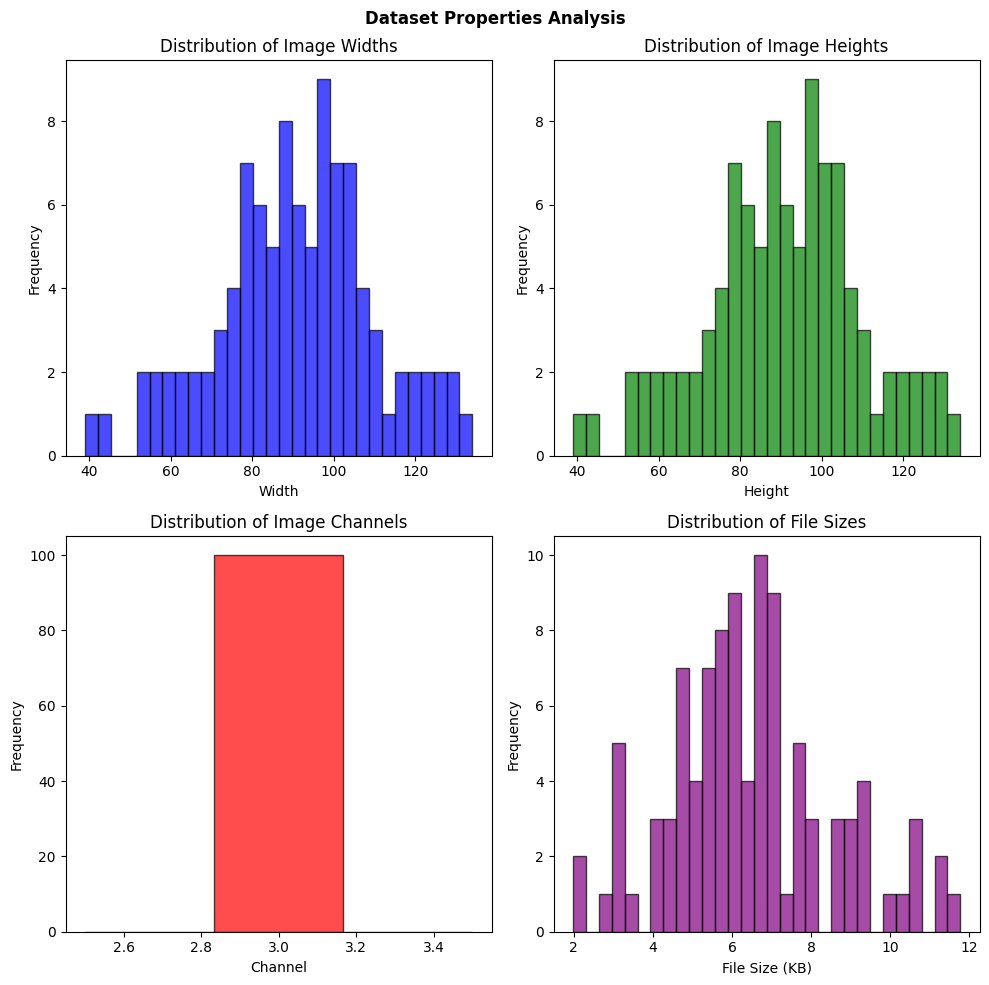

In [64]:
fig ,axes = plt.subplots(2,2, figsize=(10,10))
fig.suptitle("Dataset Properties Analysis", fontweight='bold')

axes[0,0].hist(image_stats['width'],bins=30,alpha =0.7 , color='blue', edgecolor='black')
axes[0,0].set_xlabel('Width')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Image Widths')

axes[0,1].hist(image_stats['height'],bins=30,alpha =0.7 , color='green', edgecolor='black')
axes[0,1].set_xlabel('Height')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Image Heights')

axes[1,0].hist(image_stats['channel'],bins=3  ,alpha =0.7 , color='red', edgecolor='black')
axes[1,0].set_xlabel('Channel')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Image Channels')

axes[1,1].hist([size/1024 for size in image_stats['file_size']], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_xlabel('File Size (KB)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of File Sizes')

plt.tight_layout()
plt.show()